In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import QTable
%matplotlib inline
import pdb
from datetime import datetime
from matplotlib.dates import DateFormatter
from astropy.stats import LombScargle
import scipy.optimize as optimize

# Observing Project 2

This project focused on observing variable stars and determining their periods from our collected data. We collected data over two weekends, totalling eight nights of observing, however we were unable to observe for four of those nights due to weather and smoke from nearby fires. Thankfully, we had collected a large number of images of our KIC targets on the first weekend. We were also also sharing our data with the entire class, increasing our sample size. 


## CoRoT 2b - Exoplanet
On the first weekend, we took time-series data of a confirmed exoplanet orbiting CoRoT 2. We took advantage of a python script from Astro 480 that allowed us to filter stars/exoplanet candidates by when they occured. CoRoT 2b was at the perfect time and for the perfect duration. We took 470 images in total over the night and performed the proper image reduction (with Flats, Bias and Darks that were taken same night) and photometric techniques, including alignment, on all 470 of them. No data was thrown out.

During the processing of CoRoT2b, we determined that we had to align the images. In order to do so, David had found an image processing software "AstroImageJ" that would allow us to do so, without the need to struggle with "imalign" in IRAF/PyRAF. After the images were aligned and reduced, photometry was perfomed with IRAF to produce mag files for each image. We used "txdump" to dump the relevant data from the mag files into the data that is read in below, in a format that is shown after the print statements at the end of the next cell.  

The cell below reads in the data using AstroPy, sorts it by star ID, and performs differential photometry, subtracting the target stars magnitude by the average magnitude of the other "reference" stars. The resulting plot is then displayed with the Y-axis being Relative Magnitude (with included errorbars) and the X-axis being Time (UTC) during our night of observation. 

CoRoT2 Mag: 15.0580276596
Max Change in Mag: 0.1925
Percentage Change in Mag: 1.27838787623 %


Example Table
 id  mag    merr  otime  
--- ------ ----- --------
  1 15.057 0.003 06:35:06
  2  14.85 0.003 06:35:06
  3 16.666 0.009 06:35:06
  4 17.563 0.016 06:35:06
  5 17.398 0.015 06:35:06
  6  16.63 0.008 06:35:06
  7 16.637 0.008 06:35:06
  1 15.057 0.003 06:35:32


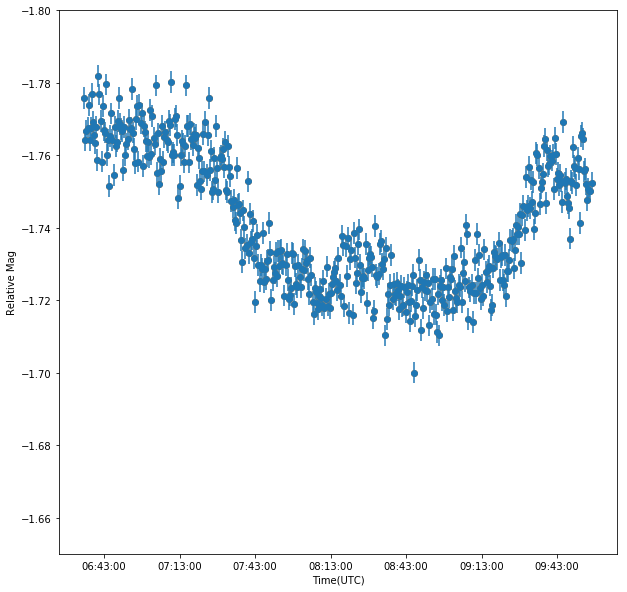

In [2]:
corot_data = QTable.read('COROT2b.txt', format='ascii')

def plotCorot():
    min_id = min(corot_data['id'])
    max_id = max(corot_data['id'])
    id_list = np.arange(1,max_id+1,1)
    star1_mask = np.where(corot_data['id'] == 1)
    star2_mask = np.where(corot_data['id'] == 2)
    star3_mask = np.where(corot_data['id'] == 3)
    star4_mask = np.where(corot_data['id'] == 4)
    star5_mask = np.where(corot_data['id'] == 5)
    star6_mask = np.where(corot_data['id'] == 6)
    star7_mask = np.where(corot_data['id'] == 7)

    star1_data = corot_data[star1_mask]
    star2_data = corot_data[star2_mask]
    star3_data = corot_data[star3_mask]
    star4_data = corot_data[star4_mask]
    star5_data = corot_data[star5_mask]
    star6_data = corot_data[star6_mask]
    star7_data = corot_data[star7_mask]
    star_avg_data = np.array([])
    time_data = np.array([])

    for (star2, star3, star4, star5, star6, star7) in zip(star2_data,star3_data,star4_data,star5_data,star6_data,star7_data):
        mag2 = star2['mag']
        mag3 = star3['mag']
        mag4 = star4['mag']
        mag5 = star5['mag']
        mag6 = star6['mag']
        mag7 = star7['mag']
        time = star2['otime']
        time = datetime.strptime(time,'%H:%M:%S')
        avg_mag = (mag3  + mag5 + mag6 + mag7)/4
        star_avg_data = np.append(star_avg_data, avg_mag)
        time_data = np.append(time_data,time)
        
    diff_data = star1_data['mag'] - star_avg_data
    print ('CoRoT2 Mag: '+ str(np.mean(star1_data['mag'])))
    print ('Max Change in Mag: '+ str(abs(max(diff_data) - min(diff_data))))
    print ('Percentage Change in Mag: ' + str((max(diff_data)-min(diff_data))/np.mean(star1_data['mag'])*100) +' %\n\n\nExample Table')
    print (corot_data[:8])
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(10,10)

    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.errorbar(time_data, diff_data, star1_data['merr'],fmt='o')
    ax.plot_date(time_data, diff_data)
    ax.set(xlabel='Time(UTC)', ylabel='Relative Mag',ylim=(-1.65,-1.8));


plotCorot()


There is a very prominent dip (~1%), adequately displaying the transit of an exoplanet in front of our target star. You do see an increase in brightness close to the center of the transit. This could just be an anamoly in our data, or could represent some sort of physical occurence (flares, nearby star if in binary system, some kind of ground effect, etc.). 

During our calculations for differential photometry, we decided to throw away stars 2 and 4, due to their weird behavior when compared to the average magnitude. This was originally in an attempt to remove the large increase in the middle of transit, however it was still present after removing stars 2 and 4 from our average calculations. 
 

## KIC Targets

The remainder of this projected was focused on observing KIC targets, 3 eclipsing binaries and 3 RR Lyrae stars. Again, we were only able to observe four out of eight total nights. However, despite not collecting as much data as we'd hoped, there was a class-wide effort in determining the periods of the following KIC targets. We shared all of our data, processed all the images, and performed photometry for each one to obtain magnitudes and errors. 

The below cell defines a few useful functions that are used for each KIC target. "doDiffPhot" takes in the magnitude data, sorts it according to star ID (where ID = 1 is our target star), averages the other stars' magnitudes, and performs differential photometry by subtracting the target star's magnitude from the average of the other "reference" star magnitudes for that time. It returns a list of magnitudes, their respective errors, and times to allow for easy ploting. The next function "doLombScargle" performs the Lomb Scargle algorithm to determine the period from our obtained data. 

In [3]:
def doDiffPhot(data,names):
    other_stars = np.where(data[:,0] != 1)
    target_star = np.where(data[:,0] == 1)
    
    
    other_data = data[other_stars]
    target_data = data[target_star]
    
    other_mags = other_data[:,1]
    target_mags = target_data[:,1]
    
    other_merr = other_data[:,2]
    target_merr = target_data[:,2]
    
    target_time = target_data[:,3]
    diff_mags = np.array([])
    for idx,time in enumerate(target_time):
        time_mask = np.where(other_data[:,3]==time)
        time_data = other_data[time_mask]
        mags_per_time = time_data[:,1]
        mean_mag_per_time = np.mean(mags_per_time)
        diff_target_mag = target_mags[idx] - mean_mag_per_time
        diff_mags = np.append(diff_mags, diff_target_mag)
        
        #if other_data[:,3] == time:
            
    
    
    target_time = target_time - min(target_time)

    return diff_mags, target_merr, target_time

def doLombScargle(time, mag):
    freq, power = LombScargle(time, mag).autopower(method='chi2', nyquist_factor = 10)
    period = 1/freq[np.argsort(power)[-1]]
    return period


The following cell reads in the data, defines a plotting function to be used for each star, and plots the relative magnitudes for each KIC target relative to the averaged reference stars, with corresponding error bars in green. 

Target	LombScarPeriod		ActualPeriod(day)	%err
KIC124	0.120648085238		0.2413212		0.500051859355
KIC373	0.682193400438		0.6820264		0.000244859198564
KIC555	0.621682560878		0.620669		0.00163301353583
KIC787	0.121434822701		0.2429038		0.500070304785
KIC798	0.579864344507		0.5811436		0.00220127261734
KIC947	0.125793490101		0.1257653		0.000224148481273


/home/dm1681/anaconda3/envs/astroML/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


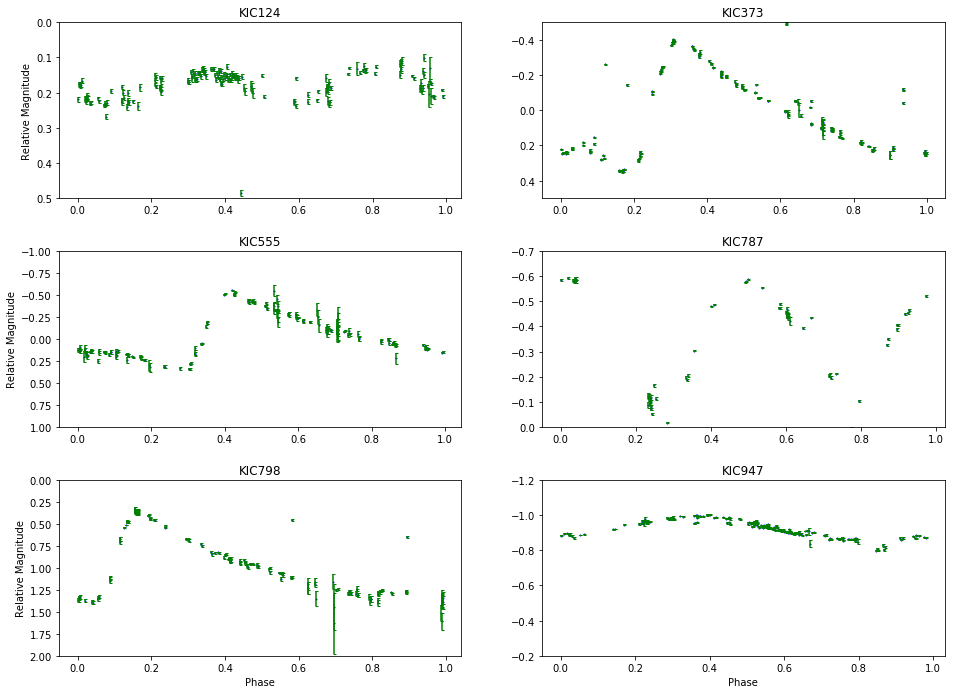

In [4]:
np.set_printoptions(precision = 13)
data_124 = np.loadtxt('KIC124.txt',dtype=np.float64)
data_373 = np.loadtxt('KIC373.txt',dtype=np.float64)
data_555 = np.loadtxt('KIC555.txt',dtype=np.float64)
data_787 = np.loadtxt('KIC787.txt',dtype=np.float64)
data_798 = np.loadtxt('KIC798.txt',dtype=np.float64)
data_947 = np.loadtxt('KIC947.txt',dtype=np.float64)

data_set = np.array([data_124, data_373, data_555, data_787, data_798, data_947])
names_set = np.array(['124', '373', '555', '787','798','947'])
correct = np.array([0.2413212, 0.6820264, 0.620669, 0.2429038, 0.5811436, 0.1257653])
per_list = np.array([])
ampl = np.array([1, 1, 1, 1, 1, 1])
offset = np.array([1, 1, 1, 1, 1, 1])
phase = np.array([1, 1, 1, 1, 1, 1])

def plotData(t, mag, merr,amp, offset, period, phase, name, i):
    name_mask = np.where(names_set == name)
    cor_per = correct[name_mask]
    plot_id = 321 + i 
    time = (t%cor_per)/cor_per
    time_LS = (t%per_list[i])
    ax = fig.add_subplot(plot_id)
    ax.errorbar(time, mag, yerr=merr,fmt='none',color='green',capsize=1.5, capthick=1)    
    ax.scatter(time, mag, s=1, color='blue')
    ax.invert_yaxis()

    if name == '947':
        ax.set(ylim=(-1.2, -0.2), title='KIC'+name, xlabel='Phase')
        ax.legend(loc='upper center',bbox_to_anchor=(-0.5,1))
        ax.invert_yaxis()
    elif name == '124':
        ax.set(ylim=(0,0.5), title='KIC'+name, ylabel='Relative Magnitude')
        ax.invert_yaxis()
    elif name == '373':
        ax.set(ylim=(-0.5,0.5), title='KIC'+name)
        ax.invert_yaxis()
    elif name == '555':
        ax.set(ylim=(-1,1), title='KIC'+name, ylabel='Relative Magnitude')
        ax.invert_yaxis()
    elif name == '787':
        ax.set(ylim=(-0.7,0), title='KIC'+name)
        ax.invert_yaxis()
    elif name == '798':
        ax.set(ylim=(0,2), title='KIC'+name, xlabel='Phase', ylabel='Relative Magnitude')
        ax.invert_yaxis()
    
        
        

fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, bottom=0.06, top=0.94, left=0.12, right=0.94)    

i = 0 
print ('Target\tLombScarPeriod\t\tActualPeriod(day)\t%err')
for names,data,corr,amp,off,pha  in zip(names_set,data_set,correct,ampl,offset,phase):
    diff,diff_merr, time = doDiffPhot(data, names)
    per = doLombScargle(time, diff)
    per_err = (per-corr)/corr
    print ("KIC"+names+'\t'+str(per)+'\t\t'+str(corr)+'\t\t'+ str(abs(per_err)))
    per_list = np.append(per_list, per)
    plotData(time, diff, diff_merr, amp, off, per, pha, names, i)
    i +=1 


The above magnitudes are presented in "phase space" from 0 to 1, where 1 defines a completed period. Each figure is normalized using the correct period determined from online databases (http://keplerebs.villanova.edu/search,http://www.aavso.org/vsx/index.php?view=detail.top&oid=12430&image=poss2ukstu_blue) and various papers(http://iopscience.iop.org/article/10.1088/2041-8205/713/2/L198/pdf). 

Prior to the figure is a list of the periods with the largest powers calculated using LombScargle. It's clear that Lomb Scargle was very accurate in determining the period for each target. However, instead of finding the correct period, Lomb Scargle returned the "fundamental mode" of the actual period (frequency) for KIC787 and KIC124. This is reinforced with the fact the % error for each was 50%, and that in each of their respetive figures, we see two well defined peaks/troughs. 

Unforunately, some of the data had to be deleted, due in INDEF values calculated during the photometry, which might be noticed by a few gaps in our plots. Fortunately, we had plenty of data to still get very accurate estimations for the periods. 

## Source of Error
This project was an endeavour encompassing every person in the class. Each person was responsible for some part of the collection of data, processing of data, and analysis of data. In that sense, the probability for human error is significantly high, escpecially since none of us are experienced professionals with years of experience working together doing this type of science. Therefore, I believe that the most likely source of errors and outliers in our data was due to human error and inconsistencies in methods among groups and individuals. Each group processed the classes data separately so as to reduce this possibility, however when dealing with data collected by many individuals, there is always the possibility of mistake (e.g., using incorrect filter and not reporting it, an inconsistency in naming conventions, etc.) . 

As for mistakes in the analysis, we did our best to determine which stars should and should not be used as reference stars in determining the averaged magnitudes. This will also almost certainly vary from group to group (or even individual) as well, and could be responsible for inaccurate reporting of the calculated periods by the Lomb Scargle algorithm. I tried a few methods to improve the accuracy of Lomb Scargle, one of which being averaging the three periods with the largest powers, and using that as a measure of period. There were no significant improvements to our calculations, so we went with the original values.

Finally, despite the two cases in which Lomb Scargle suggested the fundamental mode of the true periods, our calculations were very accurate with errors of less than 1%. 